In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [4]:
def get_random_h():
    z = torch.randn((50, 16))     
    return z

In [5]:
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [6]:
fixed_data, fixed_cl = next(iter(test_loader))
fixed_h = get_random_h()
fixed_z_label = torch.tensor(list(range(10))).repeat((5))

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [10]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._enc = FullyConnected([28*28, 1024, 1024, self.latent_size], activation_fn=nn.LeakyReLU(0.2), 
                                   last_fn=nn.Sigmoid(), flatten=True)
               
        self._dec = FullyConnected([self.latent_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), 
                                   last_fn=nn.Tanh())
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
   
   
    
    def encode(self, x):
        h = self._enc(x)       
        return h
    
    def decode(self, h):        
        x = self._dec(h)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output.view(-1, 1, 28, 28), data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(torch.randn((batch_size, self.latent_size)))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [11]:
models = {
   # 'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [13]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [28]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            with torch.no_grad():
                print ("Model {}:".format(k))
                ae_data = models[k].forward(fixed_data).view(-1, 1, 28, 28).data.numpy()
                fixed_gen = models[k].decode(fixed_h).view(-1, 1, 28, 28).data.numpy()
                random_gen = models[k].decode(get_random_h()).view(-1, 1, 28, 28).data.numpy()
                plot_mnist(ae_data, (5, 10))
                plot_mnist(fixed_gen, (5, 10)) 
                plot_mnist(random_gen, (5, 10)) 

                encoded = model.encode(fixed_data[:10])
                enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
                plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.0177 D:0.0004
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.0492 D:0.0004
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.0541 D:0.0003
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.0686 D:0.0004
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1190 D:0.0002
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.0557 D:0.0004
Model Adam Discr+bn+dp:


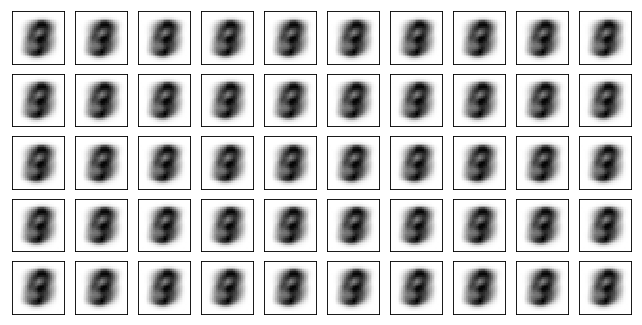

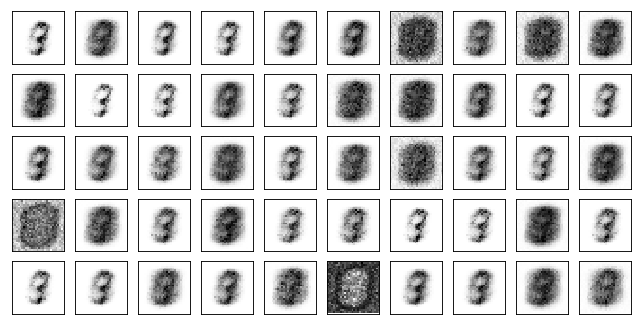

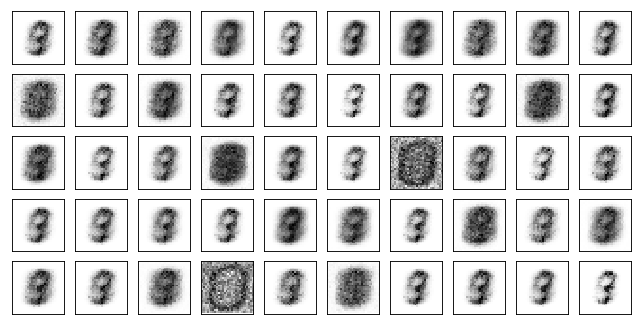

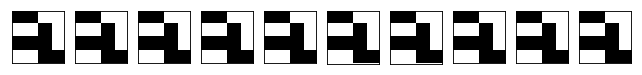

Test losses: 
Adam Discr+bn+dp: 1.34613216 / 3.90017152 / 0.00135546 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.0224 D:0.0004
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.0834 D:0.0003
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.1111 D:0.0002
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:0.6616 D:0.0299
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:0.7479 D:0.0672
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.8294 D:0.0029
Model Adam Discr+bn+dp:


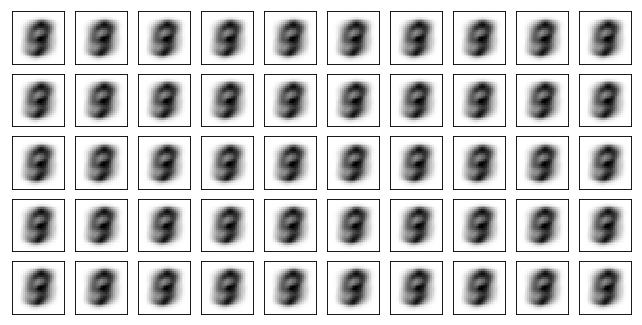

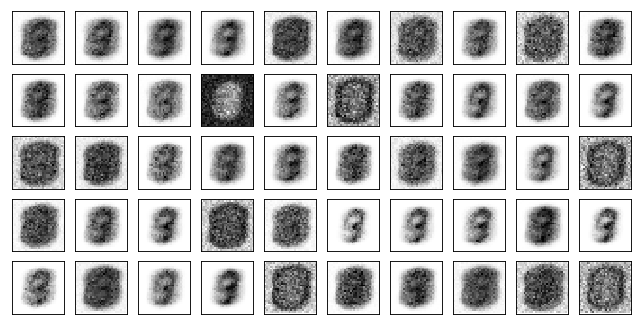

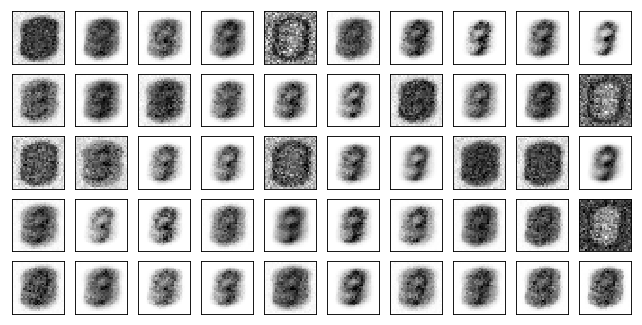

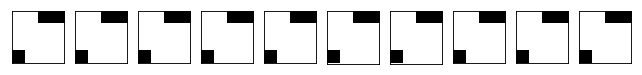

Test losses: 
Adam Discr+bn+dp: 1.34780991 / 2.83450723 / 0.02197181 

Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:0.8201 D:0.0027
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:0.8478 D:0.0028
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:0.9080 D:0.0014
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:0.9325 D:0.0016
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:0.9558 D:0.0019
Train Epoch: 3 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.9677 D:0.0010
Model Adam Discr+bn+dp:


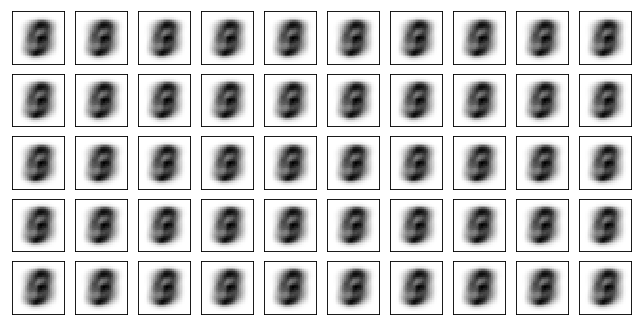

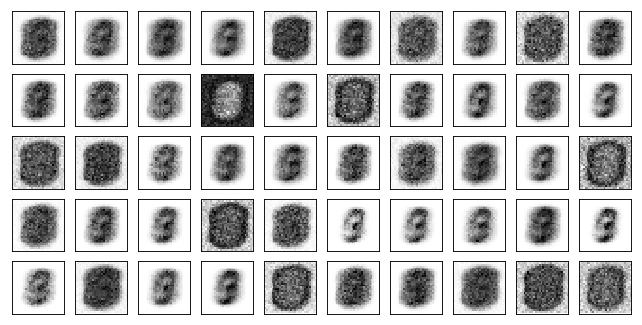

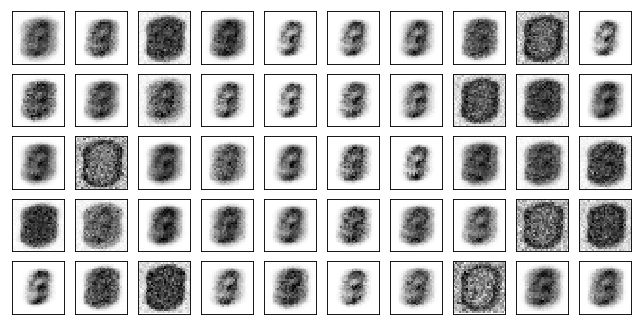

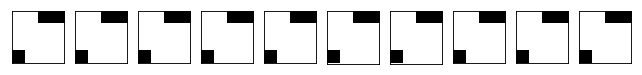

Test losses: 
Adam Discr+bn+dp: 1.34664655 / 3.52638936 / 0.00492445 

Train Epoch: 4 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:0.9083 D:0.0011
Train Epoch: 4 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:0.9884 D:0.0006
Train Epoch: 4 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:0.9718 D:0.0008
Train Epoch: 4 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:0.9604 D:0.0007
Train Epoch: 4 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:0.9889 D:0.0007
Train Epoch: 4 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.9976 D:0.0005
Model Adam Discr+bn+dp:


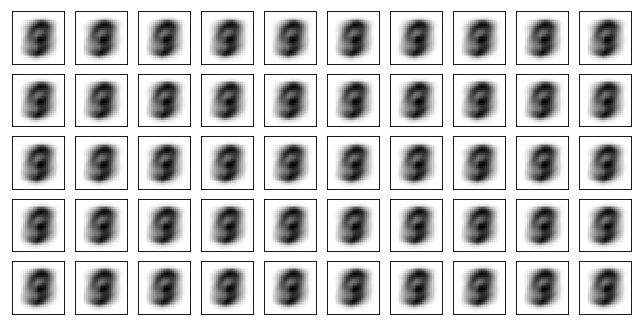

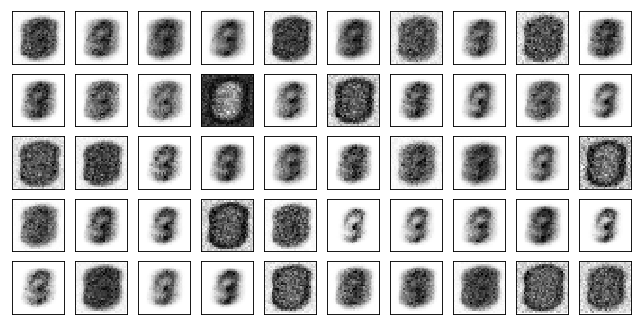

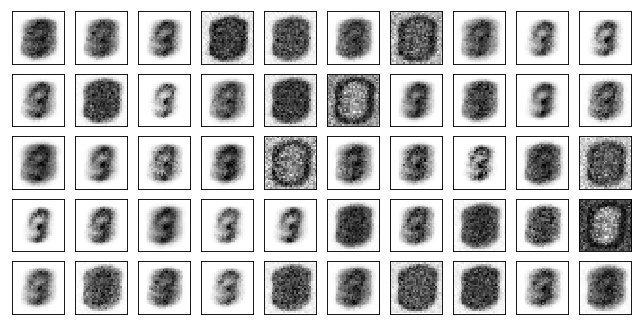

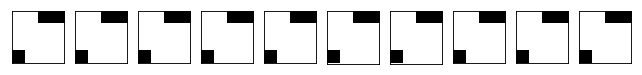

Test losses: 
Adam Discr+bn+dp: 1.34633470 / 3.83361340 / 0.00191308 

Train Epoch: 5 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.0090 D:0.0005
Train Epoch: 5 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.0208 D:0.0005
Train Epoch: 5 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.0457 D:0.0004
Train Epoch: 5 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.0228 D:0.0004
Train Epoch: 5 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.0402 D:0.0003
Train Epoch: 5 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.0747 D:0.0003
Model Adam Discr+bn+dp:


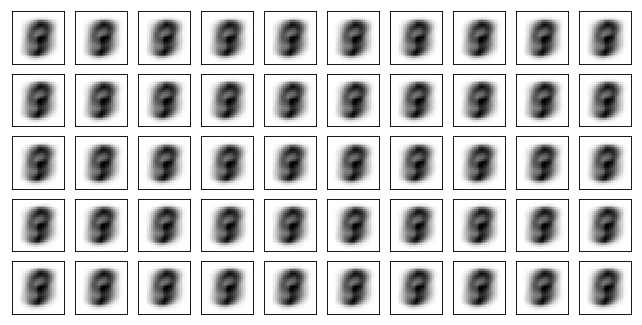

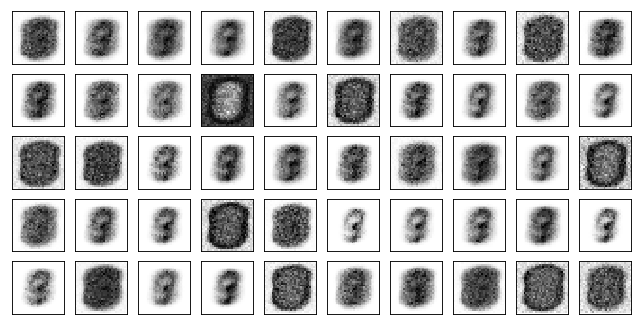

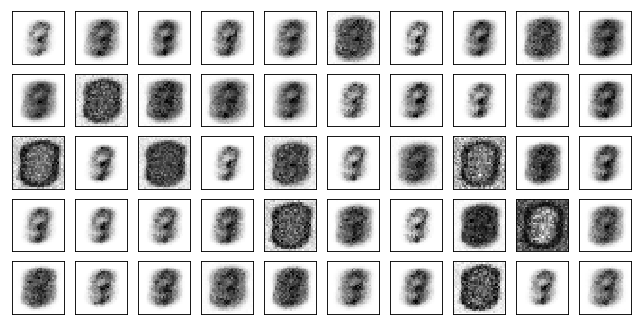

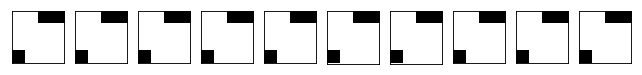

Test losses: 
Adam Discr+bn+dp: 1.34585798 / 4.17330122 / 0.00090909 

Train Epoch: 6 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.0997 D:0.0003
Train Epoch: 6 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.0976 D:0.0002
Train Epoch: 6 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.0636 D:0.0003
Train Epoch: 6 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.0580 D:0.0003
Train Epoch: 6 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1214 D:0.0002
Train Epoch: 6 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.1351 D:0.0001
Model Adam Discr+bn+dp:


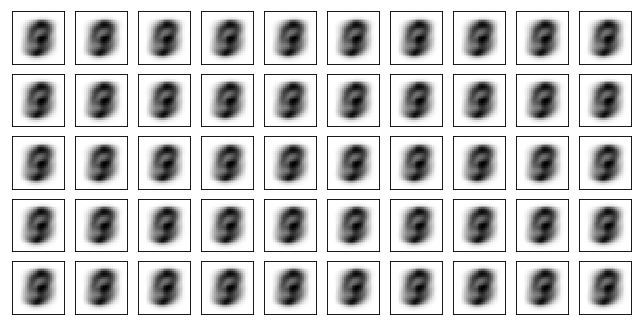

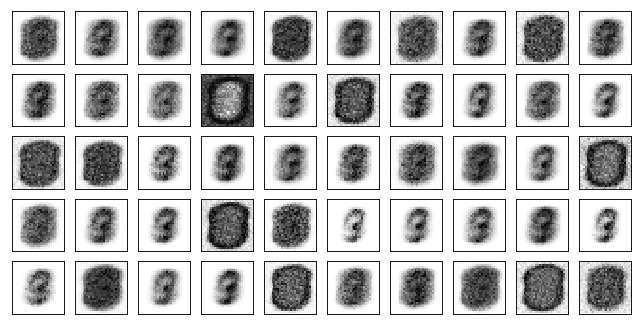

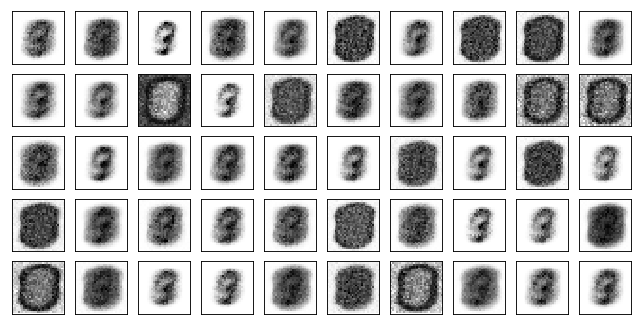

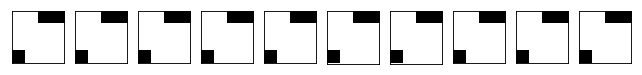

Test losses: 
Adam Discr+bn+dp: 1.34547377 / 4.47869301 / 0.00050466 

Train Epoch: 7 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.1540 D:0.0002
Train Epoch: 7 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.1179 D:0.0002
Train Epoch: 7 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.1813 D:0.0001
Train Epoch: 7 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.1445 D:0.0001
Train Epoch: 7 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1583 D:0.0002
Train Epoch: 7 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.1805 D:0.0001
Model Adam Discr+bn+dp:


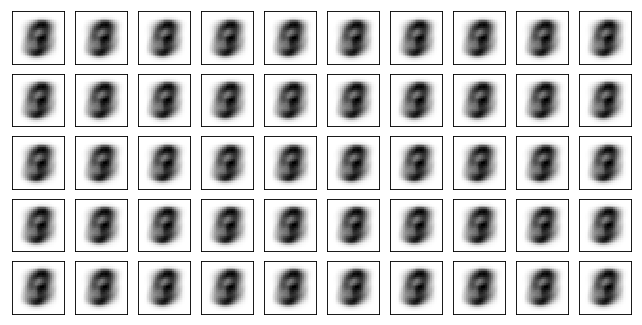

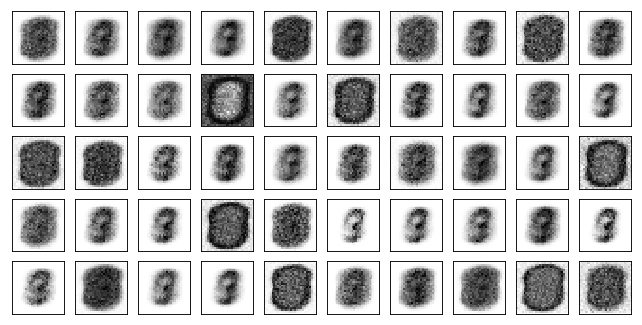

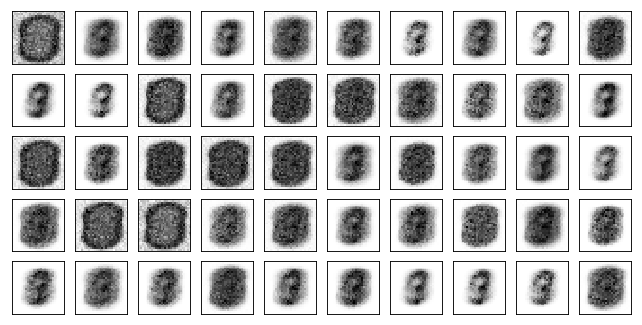

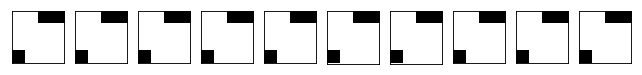

Test losses: 
Adam Discr+bn+dp: 1.34664536 / 4.59374285 / 0.00037854 

Train Epoch: 8 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.1294 D:0.0001
Train Epoch: 8 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.1116 D:0.0002


KeyboardInterrupt: 

In [29]:
for epoch in range(1, 71):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [ ]:
torch.save(models['Adam Discr+bn+dp'], './adam_fc_nooh')

### Вывод результатов

In [ ]:
model = torch.load('./adam_fc_nooh')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 16))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()